# Introduction
The goal of this notebook is to calibrate Monarch to match experimental volume overload data from Kleaveland et al. 1988. This notebook has two parts: 
1. Fitting the cardiac and hemodynamic parameters to match baseline (pre-MVR) and acute-MVR models
2. Fitting growth parameters to match the chronic model (post-MVR)

In [21]:
import pathlib
import pandas as pd

# Get notebook directory and store everything in a subdirectory
root_dir = pathlib.Path().absolute()
data_dir = root_dir / "data_kleaveland"
baseline_dir = root_dir / "kleaveland_baselineacute"
growth_dir = root_dir / "kleaveland_growth"

# Import csv file data as pandas dataframe and first column as index
data_baseline = pd.read_csv(data_dir / "data_baselineacute.csv", index_col=0)

# Model properties
input_file = root_dir.parent / "inputs" / "input_kleaveland"
model_constants = {"HR": 88, "HR_acute": 128, "AmRefRfwRatio": 1.36, "AmRefSwRatio": 0.53, "AmRefLARatio": 0.70,
                       "AmRefRARatio": 0.51,
                       "RfWth": 3.4, "LAWth": 3.9, "RAWth": 3.9, "SWth": 10.3}


# Enable automatically reloading modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


When rerunning this notebook, set the run_sims variable to false to skip the simulation step and only run the GPEs and implausibility calculations. Simulations ran previously will be loaded and this will tremendously speed up the process.

In [22]:
run_sims = True

# Fitting the baseline model
## Setting up the Wave class
We will use the Wave class to fit the baseline/acute model. This class is designed to fit a model to a set of data points using Bayesian History Matching. First, we decide what parameters to fit and what their expected ranges are, and compile them in a list of dictionaries (one for each parameter). It is important that the labels match (case-insensitive) the label names in the monarch change_pars function.

In [23]:
pars = {
        "SAct": {"limits": [0.050, 0.200]},
        "AmRefLfw": {"limits": [4e3, 10e3]},
        "VLfw": {"limits": [40e3, 70e3]},
        "SBV": {"limits": [300, 1500]},
        "Ras": {"limits": [0.3, 5.0]},
        "SBV_acute": {"limits": [300, 1500]},
        "Ras_acute": {"limits": [0.3, 8.0]},
        "Rmvb_acute": {"limits": [0.05, 2.0]}
    }

## Running a full BHM scheme

We now run the entire BHM process, this will take several minutes, depending on your computer. Note that many simulation in the early waves will crash because some very unrealistic parameter sets are included, but in later waves the model will behave much better since only non-implausible parameters sets are retained.

In [24]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils
from chameleon.colors import TrueColors
import pandas as pd

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)
    
    # Initialize wave    
    camo = Camouflage(i_wave, baseline_dir, wave_threshold, pars, data_baseline, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs, constants=model_constants, 
                                                                  log_file=camo.log_file, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- SBV_acute: [300.0 - 1500.0]
- Ras_acute: [0.3 - 8.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 48.0 ± 9.0
- LVESV: 19.0 ± 5.0
- LVEF: 0.61 ± 0.07
- LVEDP: 9.0 ± 3.0
- MAP: 100.0 ± 11.0
- EDWthLfw: 7.5 ± 0.3
- LVEDV_acute: 52.0 ± 16.0
- LVESV_acute: 15.0 ± 5.0
- LVEF_acute: 0.71 ± 0.06
- LVEDP_acute: 14.0 ± 2.0
- MAP_acute: 96.0 ± 16.0
- EDWthLfw_acute: 7.4 ± 0.9
- LVRF_acute: 0.36 ± 0.13


-------------
Constants:
-------------
- HR: 88
- HR_acute: 128
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0.7
- AmRefRARatio: 0.51
- RfWth: 3.4
- LAWth: 3.9
- RAWth: 3.9
- SWth: 10.3



------
Wave 1
------
Generated emulation point cloud with 1048576 points
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/beatlab/Projects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning

128 simulation pairs (baseline + acute) completed in 25.82 seconds
124 Simulations reached convergence
89 Simulations added to training data
Training GPEs using PyTorch...
Emulating 1048576 points...
Emulation completed in 10.67 seconds
309397 points remaining in NROY region (29.51% of original space)
LVESV is the most implausible output (34.08% of all points)
172455 points remaining in NROY region after limits check
NROY size change at Wave 1 is -0.84: no convergence

------
Wave 2
------
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)


128 simulation pairs (baseline + acute) completed in 27.68 seconds
126 Simulations reached convergence
98 Simulations added to training data
Training GPEs using PyTorch...
Emulating 172455 points...
Emulation completed in 1.74 seconds
35919 points remaining in NROY region (3.43% of original space)
EDWthLfw is the most implausible output (19.07% of all points)
34664 points remaining in NROY region after limits check
NROY size change at Wave 2 is -0.80: no convergence

------
Wave 3
------
Regenerating emulation cloud from 34664 to 100000 points...
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/beatlab/Projects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])


128 simulation pairs (baseline + acute) completed in 26.77 seconds
123 Simulations reached convergence
96 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.6 seconds
13690 points remaining in NROY region (1.31% of original space)
EDWthLfw is the most implausible output (21.23% of all points)
13469 points remaining in NROY region after limits check
NROY size change at Wave 3 is -0.61: no convergence

------
Wave 4
------
Regenerating emulation cloud from 13469 to 100000 points...
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar divide
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/miniconda3/envs/monarch/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/beatlab/Projects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar divide
  h_s = (model.heart.am_ref_w[2] * lab ** 2) 

128 simulation pairs (baseline + acute) completed in 24.01 seconds
124 Simulations reached convergence
93 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 2.07 seconds
3406 points remaining in NROY region (0.32% of original space)
EDWthLfw is the most implausible output (21.17% of all points)
3406 points remaining in NROY region after limits check
NROY size change at Wave 4 is -0.75: no convergence

------
Wave 5
------
Regenerating emulation cloud from 3406 to 100000 points...
Running 128 model simulations...


/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/beatlab/Projects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/beatlab/Projects/monarch/src/monarch/heart.py:307: Ru

128 simulation pairs (baseline + acute) completed in 22.70 seconds
124 Simulations reached convergence
107 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 2.72 seconds
15922 points remaining in NROY region (1.52% of original space)
EDWthLfw is the most implausible output (21.62% of all points)
15922 points remaining in NROY region after limits check
NROY size change at Wave 5 is 3.67: history matching terminated because maximum allowed number of waves has been reached


## Analyzing the results
Run and plot simulations using a randomly selected subset of the posterior distribution. Compare these results with the simulation results after we just ran the single wave with implausibility criterion of 5.0 to see the vast improvement.


---------
Posterior
---------
Running 256 model simulations...
256 simulation pairs (baseline + acute) completed in 36.91 seconds
256 Simulations reached convergence
238 Simulations added to training data


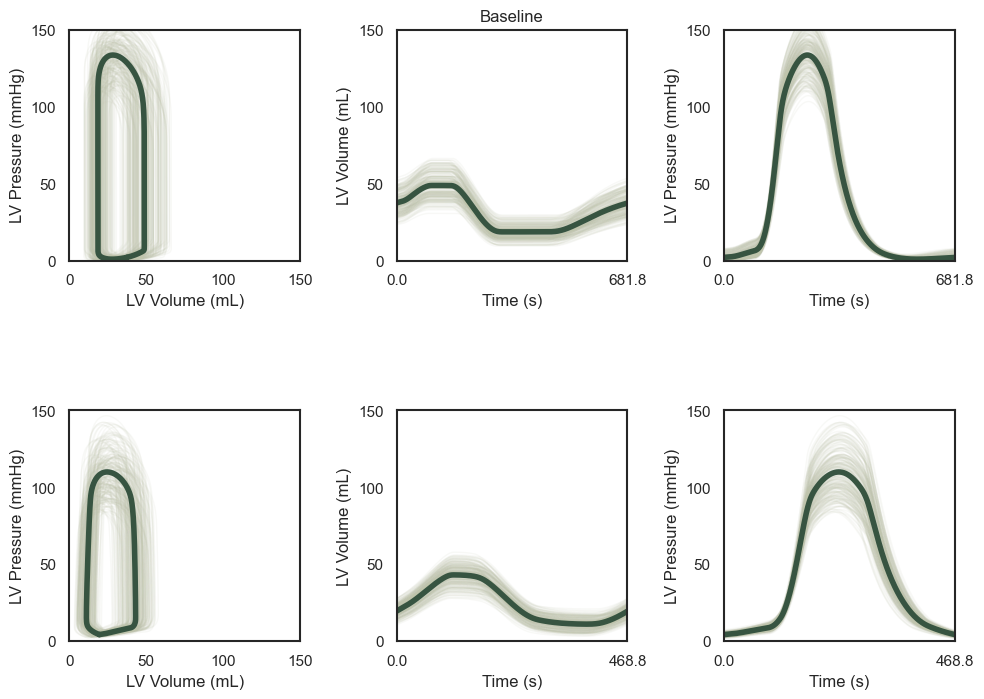

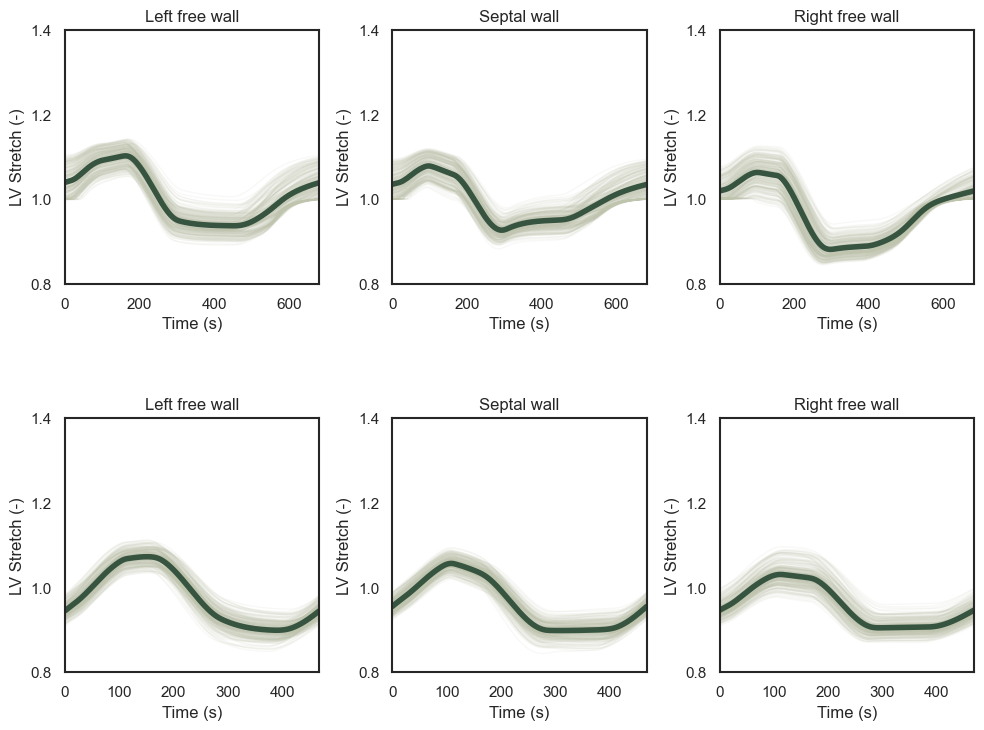

In [25]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, 
                                                         log_file=camo.log_file, show_fig=True, posterior=True)

In [26]:
camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

Now start the Tide class to further analyze the results. This class is designed to analyze the progression and final results of the fitting scheme. Because the Tide class is only dependent on the exported results from the Wave class, the following cell and all others in this section can be run independently of the rest of the notebook. First, always check if the final NROY region is within the 95% confidence interval of all data:

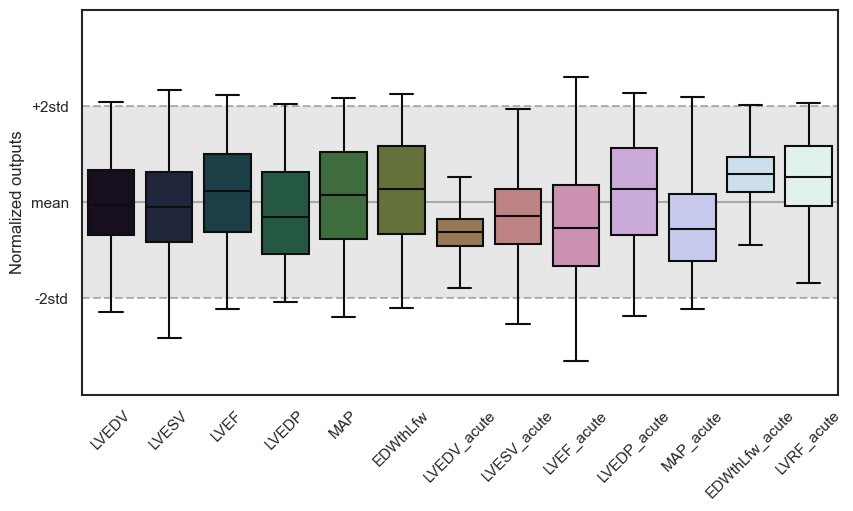

In [27]:
from chameleon.colors import TrueColors

colors = TrueColors(baseline_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box = True)

Next, inspect the final NROY region to inspect if all parameters are uniquely fitted, and if the mean of the matched distribution is close to the true values in this synthetic case. This plot is time-consuming to generate, so we here run it with a subset of 1000 randomly chosen parameter sets.

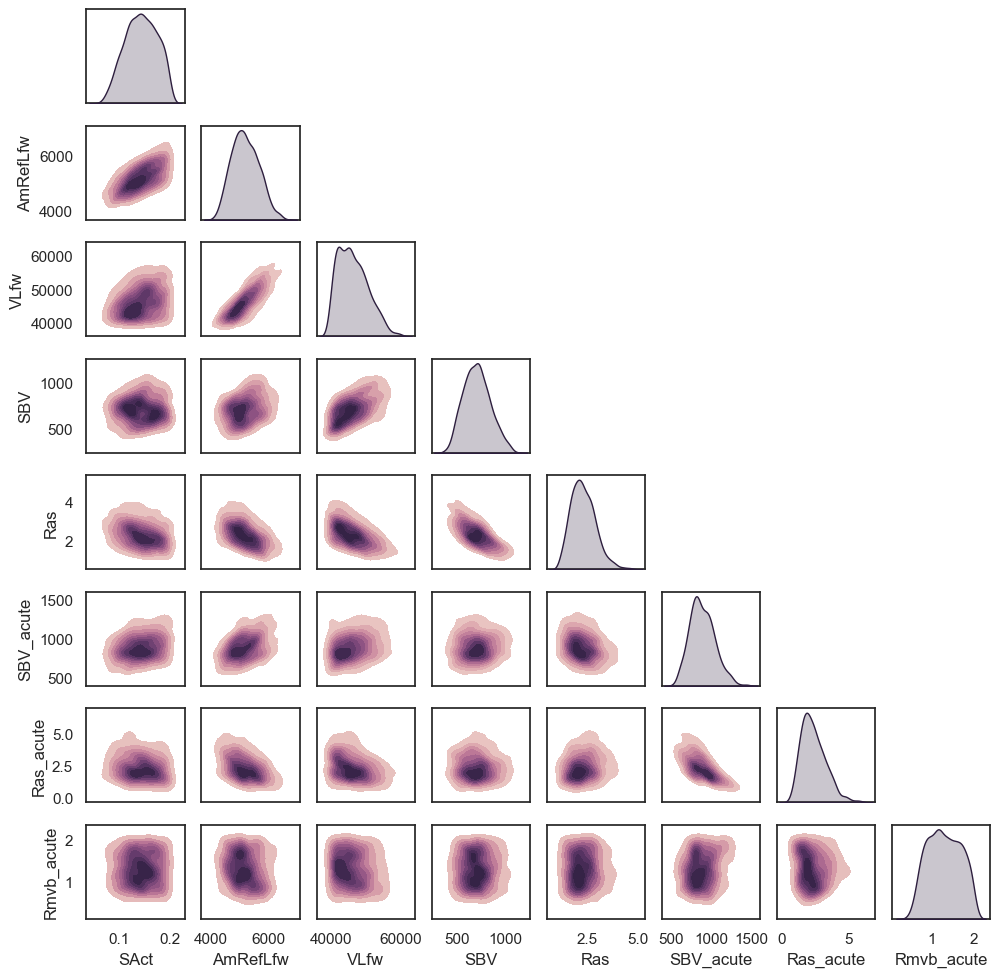

In [28]:
colors.plot_nroy_x(n_samples=1000, show_fig=True)

Run all plots, this will be time-consuming–in fact, it is slower than running BHM itself! The plots are saved in the *results* subdirectory.

KeyboardInterrupt: 

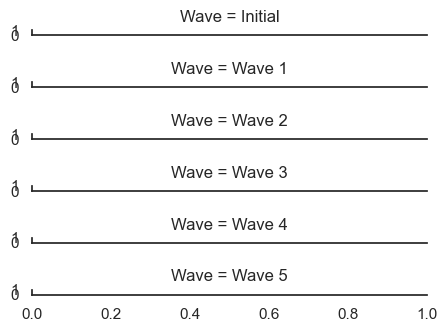

In [29]:
import matplotlib.pyplot as plt
plt.close("all")
colors.roll(nroy_full=False)

# Fitting the growth model
## Running the BHM scheme
This is done similar to the baseline/acute model, but now we need to specify the growth parameters and the limits:

In [30]:
from chameleon.camouflage import Camouflage
import chameleon.monarch_utils as model_utils 

pars = {
    "tau_f+": {"limits": [0.1, 50.0]},
    "tau_r-": {"limits": [0.1, 50.0]}
}

model_constants.update({"gamma": 2.0, "t_mem": 1e5, "tau_f-": 1e5 , "tau_r+": 1e5, 
                        "theta_f_min": 0.75, "theta_f_max": 1.5**2, "theta_r_min": 0.75, "theta_r_max": 1.5**2})
model_constants.update(
        {"tau_f-": 1e5, "tau_r+": 1e5, "theta_f_max": 1.5**2, "theta_f_min": 0.9**2,
                        "gamma": 2.0, "theta_r_max": 1.5, "theta_r_min": 0.75, "t_mem": 1e5})

We also need to specify the prior directory, which is the directory where the baseline/acute model results are stored. This is needed to initialize the growth model with the correct geometry and hemodynamics. We will use the previous baseline fit.

In [ ]:
# Import csv file data as pandas dataframe and first column as index
data_growth = pd.read_csv(root_dir / data_dir / "data_growth.csv", index_col=0)

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave
    camo = Camouflage(i_wave, growth_dir, wave_threshold, pars, data_growth, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants, prior_dir=baseline_dir, n_emu0=2**18)

    # Run simulations for all parameter sets in current wave set
    camo.x_sim, camo.y_sim, sim_dirs = model_utils.run_forest_run(camo, input_file, sim_dirs,  constants=model_constants, 
                                                                  log_file=camo.log_file, growth=True, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    camo.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = camo.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = camo.nroy
    i_wave += 1

-----------
Parameters:
-----------
- tau_f+: [0.1 - 50.0]
- tau_r-: [0.1 - 50.0]


-------------
Observations:
-------------
- LVEDV_d-1: 48.0 ± 9.0
- LVESV_d-1: 19.0 ± 5.0
- EDWthLfw_d-1: 7.5 ± 0.3
- LVEF_d-1: 0.61 ± 0.07
- LVEDV_d0: 52.0 ± 16.0
- LVESV_d0: 15.0 ± 5.0
- EDWthLfw_d0: 7.4 ± 0.9
- LVEF_d0: 0.71 ± 0.06
- LVRF_d0: 0.36 ± 0.13
- LVEDV_d30: 70.0 ± 15.0
- LVESV_d30: 20.0 ± 4.0
- EDWthLfw_d30: 7.0 ± 0.4
- LVEF_d30: 0.7 ± 0.07
- LVRF_d30: 0.52 ± 0.14
- LVEDV_d90: 85.0 ± 19.0
- LVESV_d90: 27.0 ± 7.0
- EDWthLfw_d90: 7.0 ± 0.4
- LVEF_d90: 0.68 ± 0.05
- LVRF_d90: 0.6 ± 0.14


-------------
Constants:
-------------
- HR: 88
- HR_acute: 128
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0.7
- AmRefRARatio: 0.51
- RfWth: 3.4
- LAWth: 3.9
- RAWth: 3.9
- SWth: 10.3
- gamma: 2.0
- t_mem: 100000.0
- tau_f-: 100000.0
- tau_r+: 100000.0
- theta_f_min: 0.81
- theta_f_max: 2.25
- theta_r_min: 0.75
- theta_r_max: 1.5



------
Wave 1
------
Generated emulation point cloud with 262

/Users/beatlab/Projects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...


## Analyzing the results
Run posterior simulations and plot the results:

In [ ]:
# Run simulations for all parameter sets in current wave set
x_posterior, y_posterior, _ = model_utils.run_forest_run(camo, input_file, [],  constants=model_constants, growth=True, 
                                                         log_file=camo.log_file, show_fig=False, 
                                                         posterior=True, run_sims=run_sims)

In [ ]:
from chameleon.colors import TrueColors

camo.x_posterior, camo.y_posterior = x_posterior, y_posterior
camo.pickle_wave()

colors = TrueColors(growth_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box=True)

In [ ]:
colors.roll(nroy_full=False)